## Quadratic/Linear Discriminant Analysis & Naive Bayes Classification

#### *28 October 2020*
#### *DATA 1010*

In [1]:
using StatsBase, CSV, Plots, Distributions, DataStructures

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278


Today we will discuss techniques for solving classification problems when we do not have sufficient information to implement the optimal classifier. Recall that the optimal classifier for labels $Y$ given features $(X_1,\cdots,X_d)$ is the Bayesian classifier

$$
(x_1,\cdots,x_d) \mapsto \operatorname{argmax}_{i}p_i f_i(x_1,\cdots,x_d). 
$$

Implementing the optimal Bayes classifier requires knowledge of the joint density (or probability mass function) $f$ for random variables $(X_1, \cdots, X_d, Y)$. This information is typically not available in read-world applications. Therefore, we resort to making assumptions about what the distribution $f$ looks like and try to estimate it from the data we have.

## Quadratic Discriminant Analysis (QDA)

We assume that the joint density function $f_i$ for every class $i$ is a multivariate normal distribution with mean $\mathbf{\mu}_i$ and convariance matrix $\mathbf{\Sigma}_i$: 

$$ f_i \sim \mathcal{N}(\mathbf{\mu}_i,\mathbf{\Sigma}_i).$$

Note that $\sim$ means "is distributed as". We can estimate $\mathbb{\mu}$ and $\mathbb{\Sigma}$ from the data for each class $c$:

$$ \mathbf{\hat{\mu}}_{i} = \frac{1}{n_i} \sum_{\mathbf{x} \in C_i} \mathbf{x} $$

$$ \mathbf{\hat{\Sigma}}_{i} = \frac{1}{n_i - 1} \sum_{\mathbf{x} \in C_i} ( \mathbf{x} - \mathbf{\hat{\mathbf{\mu}}}_{i} ) ( \mathbf{x} - \mathbf{\hat{\mathbf{\mu}}}_{i} )'$$

where $n_i$ denotes number of observations for class $i$, and $C_i$ denotes the set of features with corresponding to class $i$. This leads to the following classifier:

$$i^* =  \operatorname{argmax}_i \Big\{ \frac{n_i}{n (2\pi)^{d/2}|\hat{\Sigma}_i|^{1/2}} e^{-\frac{1}{2}(\mathbf{x}-\hat{\mathbf{\mu}}_i)'\hat{\Sigma}_i^{-1}(\mathbf{x}-\hat{\mathbf{\mu}}_i)} \Big\}$$

Taking the logarithm and ignoring terms that don't depend on $i$, we can find the optimal class:

$$ i^* = \operatorname{argmax}_i \Big\{ \log n_i  - \frac{1}{2} \log |\hat{\Sigma}_i| - \frac{1}{2} (\mathbf{x} -\hat{\mathbf{\mu}}_i)'\hat{\Sigma}_i^{-1}(\mathbf{x}-\hat{\mathbf{\mu}}_i) \Big\} $$

---

Let's use QDA to classify Fisher's Iris dataset. This data consists of 4 features (sepal length, sepal width, petal length and petal width) for 3 species of the Iris flower. The data contains 50 observations for each species.

**Aside:** The Iris dataset (along with MNIST handwritten digits dataset, CIFAR image dataset, and Boston housing prices dataset) is widely used for teaching ML and to compare various ML algorithms. You can find more information on this dataset here: http://archive.ics.uci.edu/ml/datasets/Iris

Let's create a Flower structure and load the data:

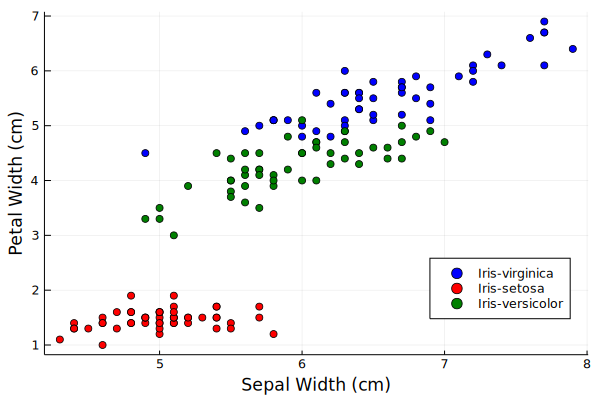

In [2]:
using CSV, Plots

struct Flower
    X::Vector
    species::String
end

df = CSV.read("iris.csv", header=false, footerskip=1)

# Use 2D feature vector, 
# consisting of values in columns 1 (sepal length in cm) and 3 (petal length in cm)
flowers = [Flower([df[i,1], df[i,3]], df[i,5]) for i = 1:size(df)[1]]

# create dictionary mapping species to color
s2c = Dict("Iris-setosa" => :red, "Iris-versicolor" => :green, "Iris-virginica" => :blue)

P = plot(xlabel = "Sepal Width (cm)", ylabel = "Petal Width (cm)", 
         legend = :bottomright, fontfamily = "Palatino")
for species in keys(s2c)
     scatter!(P, [(F.X[1], F.X[2]) for F in flowers if F.species == species], 
        color = s2c[species], label=species)
end
P

---

## Problem 1

Use QDA to train a classifier for predicting the species of flower using sepal length (in cm) and petal length (in cm). Create a heatmap showing the predicted outcome for all points in the 2-D fetaure space. What do the decision boundaries look like?

In [ ]:
# worksheet

using Statistics, Distributions

μ = Dict()
Σ = Dict()
Ns = Dict()

for species in keys(s2c)
    # μ[species] = ?
    # Σ[species] = ?
    # Ns[species] = ?
end

# TODO: write a function to predict the class given feature values

# TODO: plot heatmap

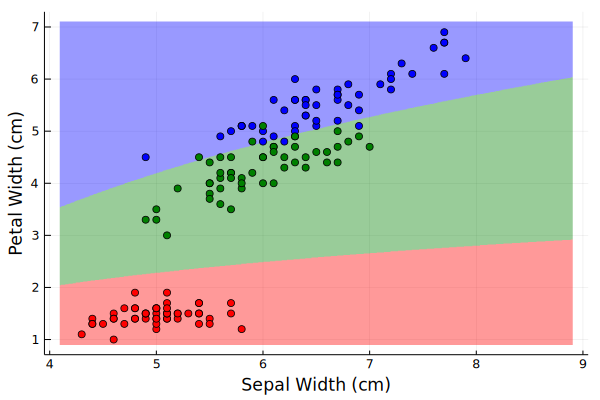

In [3]:
# solution
using Statistics, Distributions

μ = Dict()
Σ = Dict()
Ns = Dict()

for species in keys(s2c)
    μ[species] = mean([[F.X[1], F.X[2]] for F in flowers if F.species == species])
    Σ[species] = cov([[F.X[1], F.X[2]] for F in flowers if F.species == species])
    Ns[species] = MvNormal(μ[species],Σ[species])
end

predict(x, Ns) = argmax([(1.0/3.0)*pdf(Ns[species],x) for species in keys(s2c)])

xgrid = 4.1:0.01:8.9
ygrid = 0.9:0.01:7.1

rgb = [:blue,:red,:green]
P = heatmap(xgrid, ygrid, (x,y) -> predict([x,y], Ns), fillcolor = cgrad(rgb), opacity = 0.4, 
            legend = false, xlabel = "Sepal Width (cm)", ylabel = "Petal Width (cm)",
            fontfamily = "Palatino")
for species in keys(s2c)
     scatter!(P, [(F.X[1], F.X[2]) for F in flowers if F.species == species], 
        color = s2c[species], label=species)
end
P

---

## Linear Discriminant Analysis (LDA)

QDA assumes that samples for each class are drawn from a Gaussian distribution. Therefore, we estimate the mean and covariance for each class distribution from the data. Now, let's make another simplifying assumption. We assume that the covariance matrix for all class distributions are identical, i.e.

$$ \Sigma_1 = \cdots = \Sigma_c = \Sigma $$ 

where $c$ is the total number of classes. 

With this assumption, we have to estimate just one convariance matrix:

$$ \hat{\Sigma} = \frac{1}{n-c} \sum_{i=1}^{c} \sum_{\mathbf{x} \in C_i} (\mathbf{x} - \hat{\mathbf{\mu}}_i) (\mathbf{x} - \hat{\mathbf{\mu}}_i)'$$

where $\hat{\Sigma}$ is pooled over all classes $i$. The optimum class is now given by:

$$ i^*  = \operatorname{argmax}_i \Big\{ \log n_i + \log p_i - \frac{1}{2} (\mathbf{x} - \hat{\mathbf{\mu}}_i)' \hat{\Sigma}^{-1} (\mathbf{x} - \hat{\mathbf{\mu}}_i) \Big\}$$

It can be shown that this assumption results in a classifier with linear decision boundaries. Therefore, this procedure is called *Linear Discriminant Analysis* 

---

## Problem 2

Use LDA to train a classifier for predicting the species of flower for the Iris dataset. Compare its decision boundaries to those obtained from QDA above. 

In [ ]:
# worksheet

using Statistics, Distributions

μ = Dict()
Σ = zeros(2, 2)
Ns = Dict()

for species in keys(s2c)
    # μ[species] = ?
    # Σ[species] = ?
    # Ns[species] = ?
end

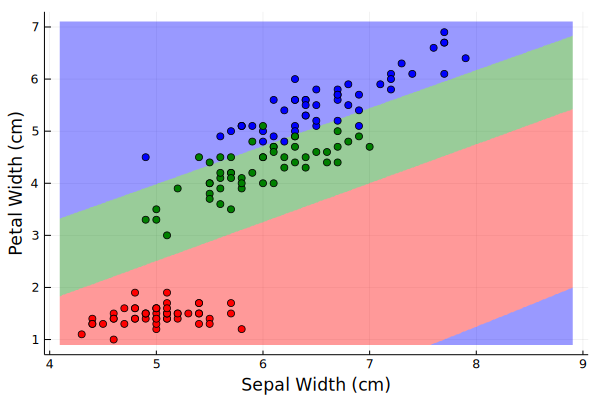

In [4]:
# solution
using Statistics, Distributions

μ = Dict()
Σ = zeros(2, 2)
Ns = Dict()

for species in keys(s2c)
    μ[species] = mean([[F.X[1], F.X[2]] for F in flowers if F.species == species])
    Σ += 49 .* cov([[F.X[1], F.X[2]] for F in flowers if F.species == species])
end

Σ = Σ/(150.0 - 3.0)

for species in keys(s2c)
    Ns[species] = MvNormal(μ[species],Σ*Σ')
end

predict(x, Ns) = argmax([(1.0/3.0)*pdf(Ns[species],x) for species in keys(s2c)])

xgrid = 4.1:0.01:8.9
ygrid = 0.9:0.01:7.1

rgb = [:blue,:red,:green]
P = heatmap(xgrid, ygrid, (x,y) -> predict([x,y], Ns), fillcolor = cgrad(rgb), 
            opacity = 0.4, legend = false, fontfamily = "Palatino",
            xlabel = "Sepal Width (cm)", ylabel = "Petal Width (cm)")
for species in keys(s2c)
     scatter!(P, [(F.X[1], F.X[2]) for F in flowers if F.species == species], 
        color = s2c[species], label=species)
end
P

---

## Naive Bayes Classification

So far, we have estimated the class conditional joint probability distributions for $(X_1,\cdots,X_d)$ as multivariate Gaussians. A different simplifying assumption we can make is that the features are independent.

We can couple this assumption with a Gaussian assumption; this amounts to setting the off-diagonal entries of the covariance matrix to zero. We can also couple it with other methods of estimating the distribution of each feature. Let's look at a discrete example.

## Problem 3

Use Naive Bayes to predict the class corresponding to a given triple of integers, given the following training data for the two classes (each row corresponds to an observation; there are 40 observations for class 1, and 40 observations for class 2). 

In [5]:
X_train = 
    [5 0 5; 7 3 10; 1 3 4; 2 2 4; 4 1 5; 2 4 6; 0 0 0; 5 1 6; 3 2 5; 2 2 4; 
     0 1 1; 1 5 6; 3 2 5; 3 2 5; 2 2 4; 0 2 2; 6 2 8; 1 1 2; 3 2 5; 3 2 5; 
     7 2 9; 3 2 5; 3 1 4; 1 4 5; 2 2 4; 2 0 2; 3 1 4; 7 4 11; 3 2 5; 5 2 7; 
     6 1 7; 3 1 4; 6 6 12; 3 1 4; 0 1 1; 1 6 7; 0 3 3; 1 2 3; 4 2 6; 3 6 9; 
     1 3 4; 2 4 6; 2 2 4; 2 3 5; 0 4 4; 1 5 6; 1 5 6; 3 4 7; 2 4 6; 0 1 1; 
     3 5 8; 1 2 3; 2 5 7; 2 7 9; 1 4 5; 7 3 10; 6 4 10; 1 5 6; 1 4 5; 0 5 5; 
     2 3 5; 2 2 4; 4 2 6; 3 2 5; 2 8 10; 1 2 3; 1 2 3; 1 2 3; 2 2 4; 2 5 7; 
     0 1 1; 1 2 3; 3 9 12; 3 3 6; 5 2 7; 1 5 6; 1 3 4; 1 4 5; 0 5 5; 1 4 5];

Y_train = repeat([1,2], inner = 40);

In [6]:
mutable struct NBBinaryClassifier
    classes
    class_proportions
    conditional_measures
end

In [6]:
# worksheet
function fit!(N::NBBinaryClassifier, X, y)
    
end

function predict(N::NBBinaryClassifier, x)
    
end

function predict(N::NBBinaryClassifier, X::Matrix)
   [predict(N,row) for row in eachrow(X)]
end

predict (generic function with 2 methods)

In [7]:
# solution
function fit!(N::NBBinaryClassifier, X, y)
    N.class_proportions = proportionmap(y)
    probability_dict(j) = [merge!(DefaultDict(0), proportionmap(X[y .== j,i])) 
                                for i in 1:size(X,2)]
    N.conditional_measures = Dict(j => probability_dict(j) for j in N.classes)
    nothing
end

function predict(N::NBBinaryClassifier, x)
    loglikelihood(j) = (log(N.class_proportions[j]) + 
        sum([log(N.conditional_measures[j][i][x[i]]) for i in 1:length(x)]))
    N.classes[argmax([loglikelihood(j) for j in N.classes])]
end

function predict(N::NBBinaryClassifier, X::Matrix)
   [predict(N,row) for row in eachrow(X)]
end

predict (generic function with 3 methods)

In [8]:
# solution
N = NBBinaryClassifier(1:2,Dict(),Dict())
fit!(N, X_train, Y_train);

In [9]:
# test data

X_test = [3 3 6; 1 1 2; 0 0 0; 2 5 7; 5 3 8; 3 2 5; 5 2 7; 1 2 3; 6 4 10; 
          5 5 10; 2 3 5; 4 4 8; 7 2 9; 4 5 9; 1 5 6; 1 2 3; 0 2 2; 3 0 3; 
          2 4 6; 3 4 7; 1 5 6; 2 1 3; 3 1 4; 3 5 8; 6 3 9; 4 1 5; 6 4 10; 
          4 5 9; 2 1 3; 4 2 6; 0 2 2; 4 3 7; 1 3 4; 2 2 4; 4 4 8; 7 2 9; 
          5 4 9; 4 2 6; 2 4 6; 1 5 6]

y_test = [fill(1, 20); fill(2, 20)]

sum(predict(N, X_test) .== y_test)

17

## Problem 4

In this problem, we'll discuss how to build a Naive Bayes classifier for identifying spam. You'll carry this plan out on your homework. 

An email body is a string, and it must be converted to a vector for us to apply the machine learning methods we've developed. One simple way to do that is to identify a vocabulary $W$ and associate each message with an element $X$ of $\{0,1\}^W$: an entry of 0 indicates the absence of a word in the email, while an entry of 1 indicates presence of the word.

(a) Consider the vocabulary W = {the, are, gift, click, money, baseball}. Vectorize each of the following sentences according to the scheme desribed above.

(i) Are you going to the baseball game?  
(ii) Congratulations! Click here for the gift card you won.

(b) Given a corpus of spam and legitimate emails, how should we estimate the probability that $X_1 = 1$?

(c) We can build Naive Bayes at the level of the message vectors. Describe the (highly contrived) email generation process that would lead to the measure on $\{0,1\}^W$ being assumed by Naive Bayes.

# worksheet

*Solution*. 

# solution

(a) The first email corresponds to the vector `[1, 1, 0, 0, 0, 1]`. The second email maps to `[1, 0, 1, 1, 0, 0]`. 

(b) We ascertain the proportion of messages which contain the first word.

(c) We loop through the vocabulary and choose for each word independently whether to include it or exclude it. 

---

## Problem 5

Repeat problems 1 and 2 above using all 4 feature vectors: sepal length, sepal width, petal length, petal width. Note that you will not be able to do the plots, since we don't have four spatial dimensions.

---

## Problem 6 (Challenge)

In the Naive Bayes example above, generate your own training matrices. Experiment with making the columns independent, and also with increasing the number of training observations.

---

## Problem 7 (Challenge)

When the number of features $d$ is large, it is standard practice to reduce dimensionality before using a classification algorithm. Many dimensionality reduction techniques exists, including PCA, t-SNE and multi-dimensional scaling. We will cover some of these next week. 

Obtain the handwritten digit dataset (from `MLDatasets`) and use t-SNE to reduce dimensionality to 2-dimensions. Compare classification performance and decision boundaries obtained by QDA, LDA and Naive Bayes for this dataset. Identify digits that are misclassified. 

In [ ]:
using MLDatasets, TSne